# **Implementing Generative Adevesarial Networks From Scratch on MNIST Dataset**

# **Importing Libraries**

In [1]:
# Import necessary libraries
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from  PIL import Image
import time
import tensorflow as tf  # Import TensorFlow
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

### **Load MNIST Dataset**

In [2]:
# Load and preprocess the MNIST dataset
# MNIST dataset contains 60,000 training images of handwritten digits

# We need only training dataset as this is Unsupervised Deep Learning

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
train_images.shape

(60000, 28, 28)

In [3]:
# Normalize and reshape

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
print(train_images.shape)

(60000, 28, 28, 1)


# **Shuffle the Images**

In [4]:
# Define buffer size and batch size
BUFFER_SIZE = 60000  # Size of the dataset
BATCH_SIZE = 256     # Batch size for training

In [5]:
# Create batches of training data and shuffle
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# **Define the Generator**

In [6]:
# The generator takes a random noise vector as input and generates a fake images

def build_generator():
    model = Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(np.prod((28, 28, 1)), activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

In [7]:
# Build the generator

generator = build_generator()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 784)                 │         803,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

# **Generate a sample image to test the generator**

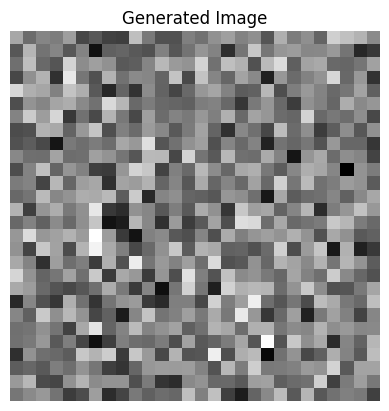

In [8]:
noise = np.random.normal(0, 1, (1, 100))

generated_image = generator(noise, training=False)  # Generate image from noise

# Display the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.title("Generated Image")
plt.axis('off')
plt.show()

# **Define the Discriminator**

In [9]:
# The discriminator takes an image (either real or generated) as input and outputs a single value
# between 0 and 1 indicating whether the image is real (1) or fake (0).

def build_discriminator():
    model = Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [10]:
# Build the discriminator

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

# **Define Losses**

In [11]:
# Define the loss function
# Binary crossentropy loss is used since we have a binary classification problem (real or fake)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [12]:
# Discriminator loss function

def discriminator_loss(real_output, fake_output):
    # Compute loss on real images (should be classified as 1)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # class 1 for real
    # Compute loss on fake images (should be classified as 0)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # class 0 fro fake
    # Total discriminator loss
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
# Generator loss function
def generator_loss(fake_output):
    # Generator tries to fool the discriminator, so we want the fake images to be classified as real (1)
    return cross_entropy(tf.ones_like(fake_output), fake_output) # classifying 1

# **Initialize Optimizers**

In [14]:
# Define optimizers for both generator and discriminator
# Adam optimizer is commonly used for its adaptive learning rate and momentum
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# **Training Parameters**

In [16]:
EPOCHS = 300               # Number of epochs to train
noise_dim = 100           # Dimension of the noise vector (latent space)
examples = 12  # Number of examples to generate for visualization


#  **Training the GAN**

In [17]:
# Define the training step function
# Use @tf.function to compile the function for faster execution
@tf.function
def train_step(images):
    # Generate random noise for input to the generator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images from the noise
        generated_images = generator(noise, training=True)

        # Get the discriminator's predictions on real and fake images
        real_output = discriminator(images, training=True)
        # fake_output contains the discriminator's predictions on the fake images.
        fake_output = discriminator(generated_images, training=True)


        # Calculate losses for both generator and discriminator

        '''Genrator Loss'''
        # The generator wants to fool the discriminator
        # The loss measures how well the generator is doing in making the discriminator believe the fake images are real
        gen_loss = generator_loss(fake_output)

        ''''Discriminator Loss'''
        # The discriminator aims to correctly classify real and fake images.
        # The loss measures how well the discriminator distinguishes between real and fake data.
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients for generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients to update the weights of generator and discriminator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
# Save and Visualise Images

def save_generated_images(epoch, examples=12):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)

    # Rescale images to [0, 1]
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize = (5,5))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 3 , i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan_generated_image_epoch_{epoch+1}.png")
    plt.show()

In [19]:
# Training function to run the training loop

def train(dataset, epochs, save_interval):
    for epoch in range(epochs):
        start = time.time()

        # Iterate over each batch of images
        for image_batch in dataset:
            train_step(image_batch)

        # Generate and save images to visualize progress
        if (epoch+1) % save_interval == 0:
          save_generated_images(epoch)

        # Time Taken for each epoch
        if (epoch+1) % save_interval == 0:
          print('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time() - start))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


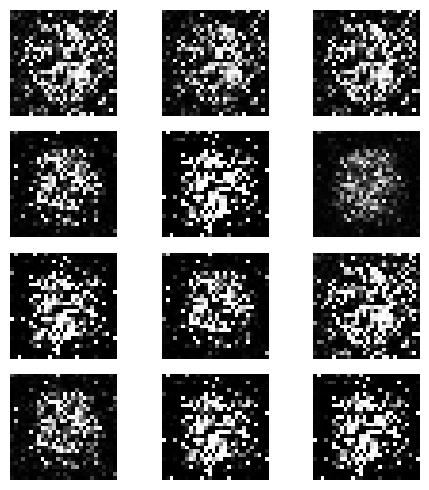

Time for epoch 5 is 2.38 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


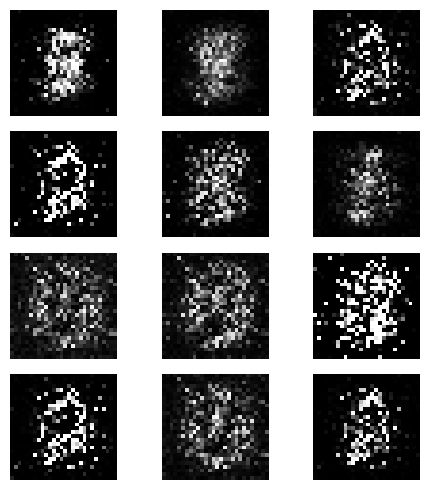

Time for epoch 10 is 2.32 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


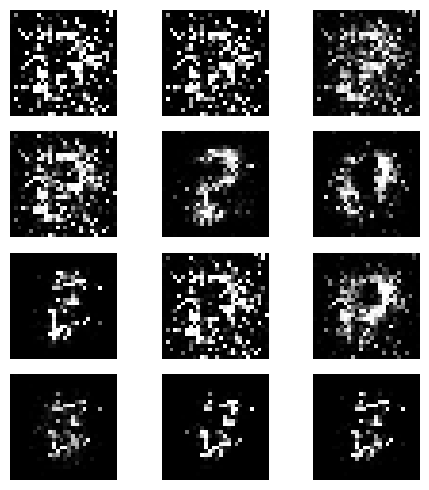

Time for epoch 15 is 1.71 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


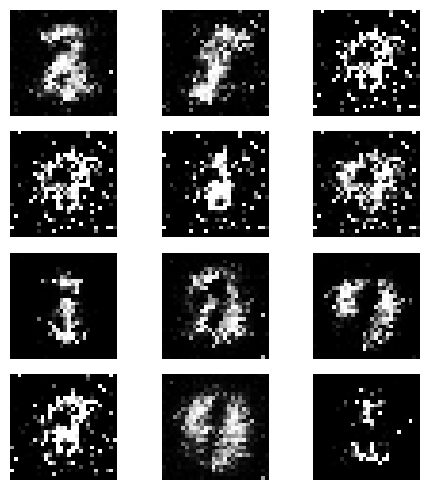

Time for epoch 20 is 1.72 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


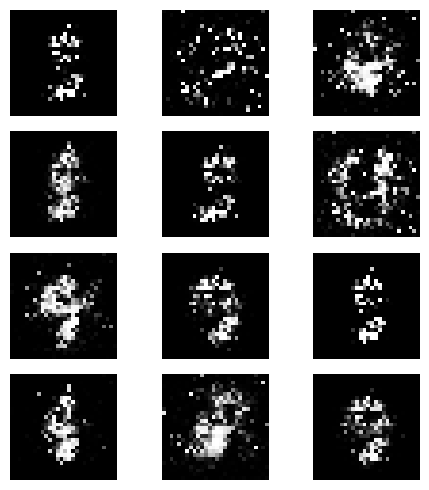

Time for epoch 25 is 1.72 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


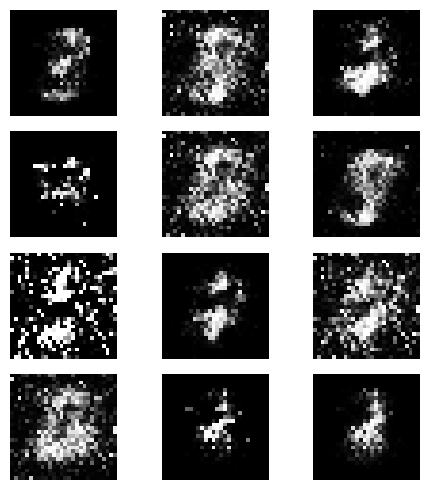

Time for epoch 30 is 1.72 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


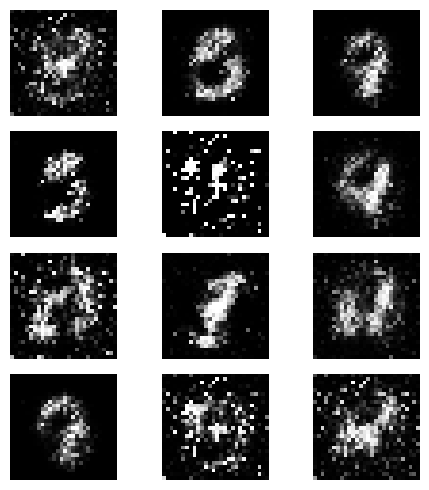

Time for epoch 35 is 2.80 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


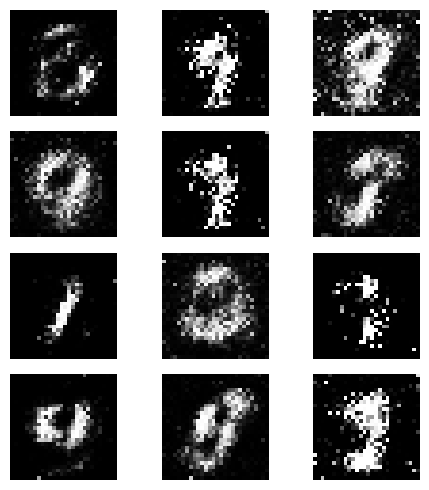

Time for epoch 40 is 2.78 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


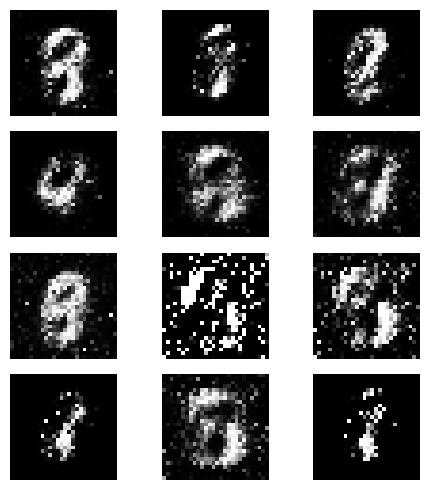

Time for epoch 45 is 4.10 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


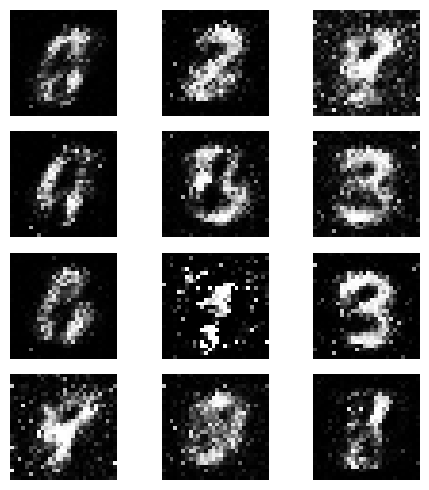

Time for epoch 50 is 1.71 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


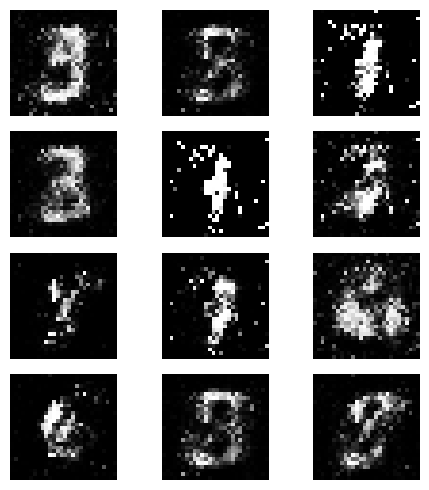

Time for epoch 55 is 1.73 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


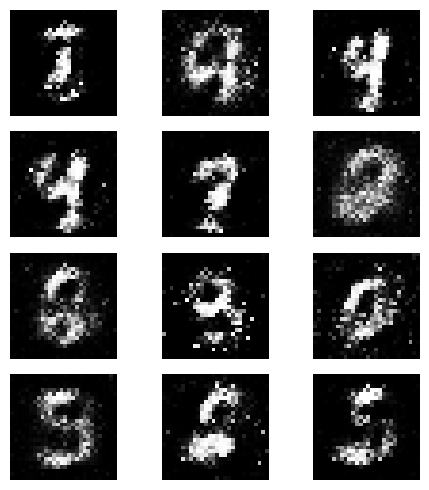

Time for epoch 60 is 3.66 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


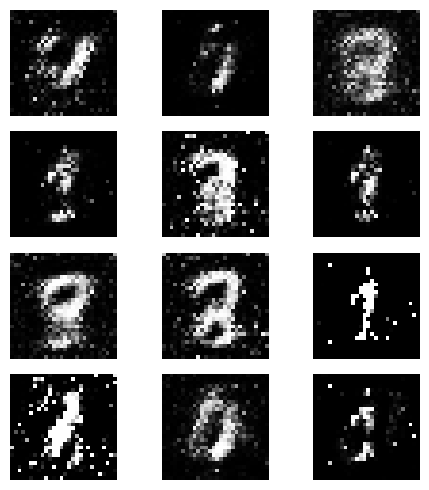

Time for epoch 65 is 1.72 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


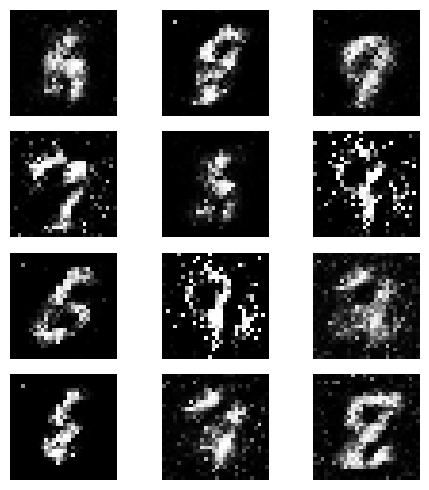

Time for epoch 70 is 2.78 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


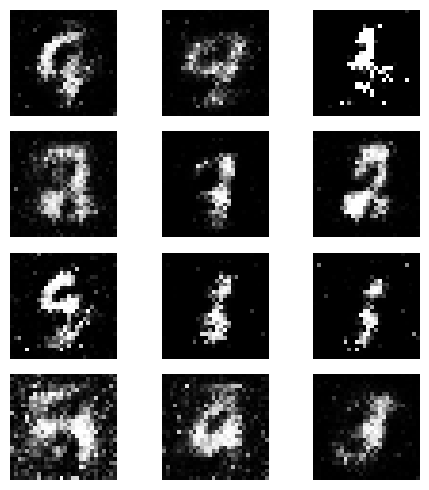

Time for epoch 75 is 3.26 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


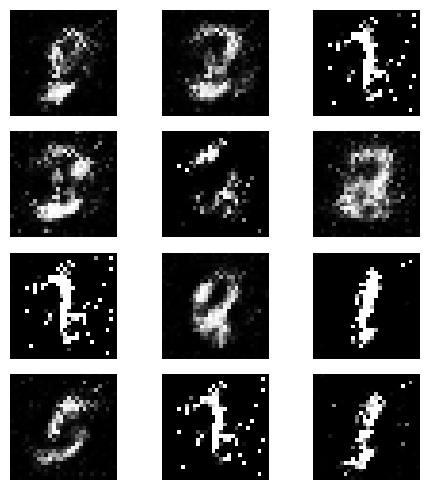

Time for epoch 80 is 1.72 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


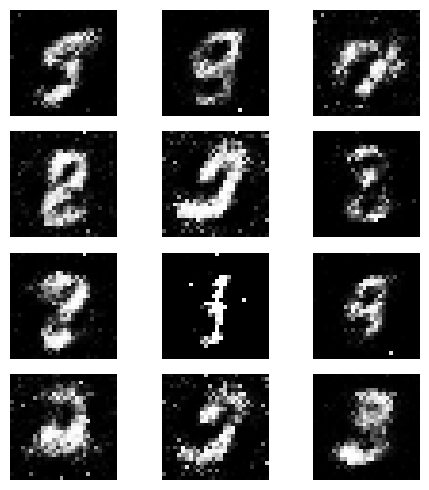

Time for epoch 85 is 1.72 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


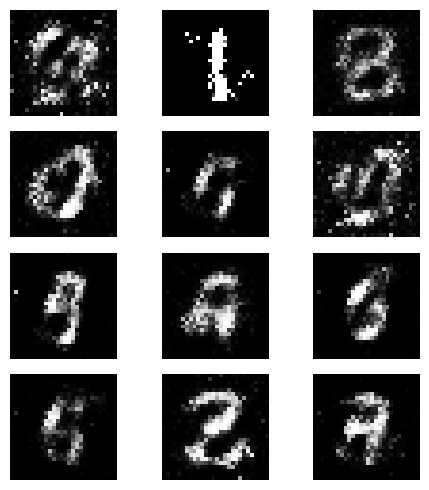

Time for epoch 90 is 2.56 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


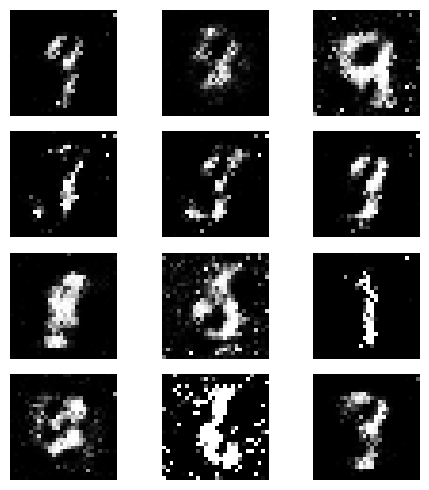

Time for epoch 95 is 1.72 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


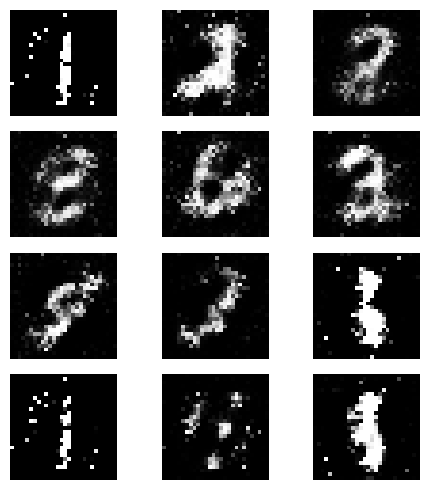

Time for epoch 100 is 2.15 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


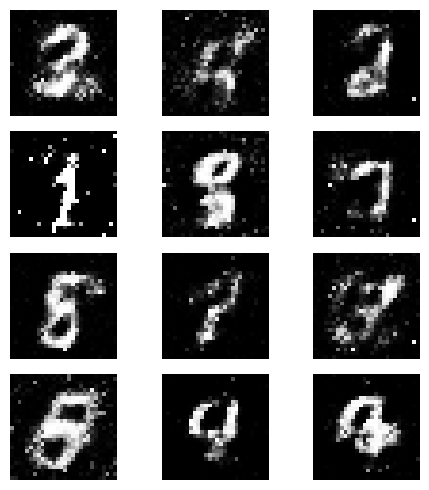

Time for epoch 105 is 2.73 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


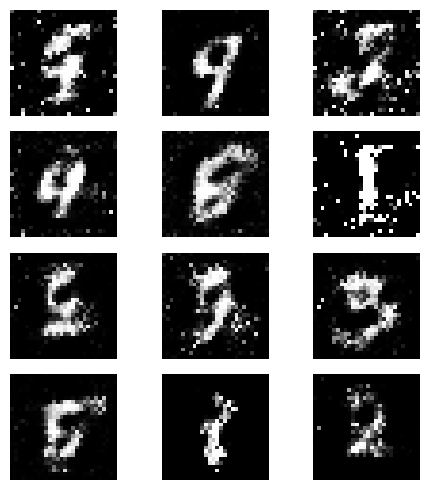

Time for epoch 110 is 1.75 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


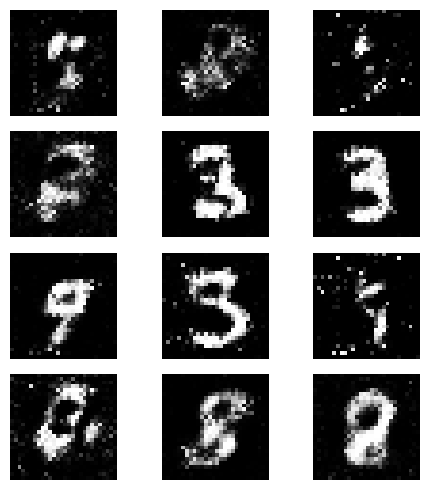

Time for epoch 115 is 1.77 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


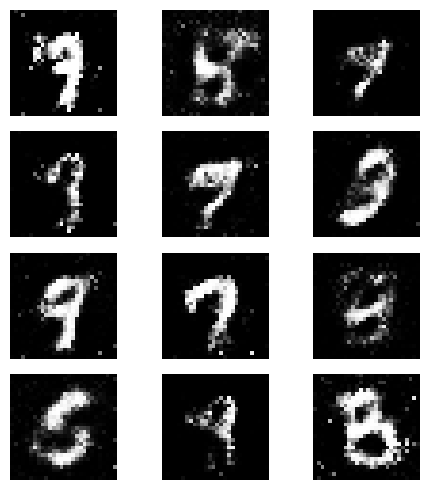

Time for epoch 120 is 2.29 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


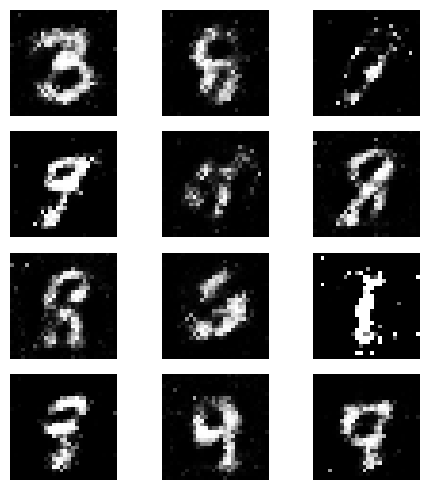

Time for epoch 125 is 1.75 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


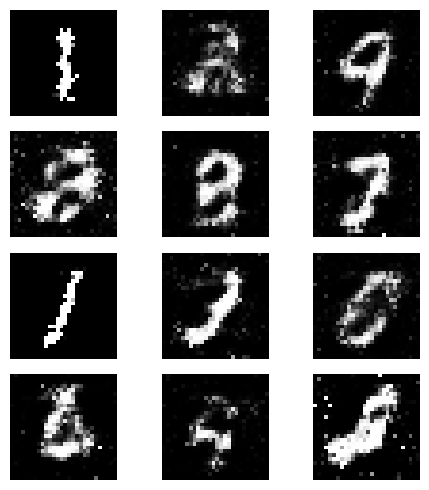

Time for epoch 130 is 1.76 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


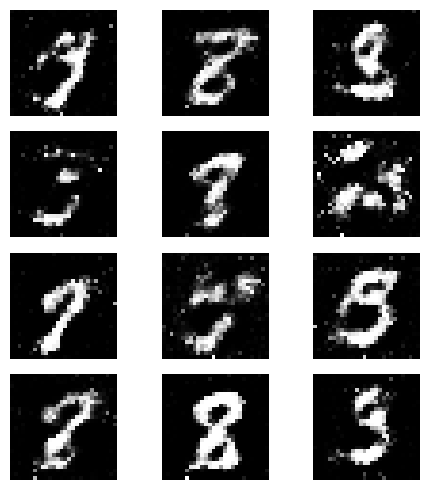

Time for epoch 135 is 1.73 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


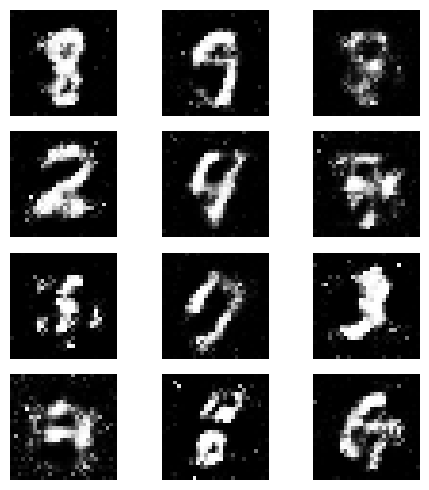

Time for epoch 140 is 1.78 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


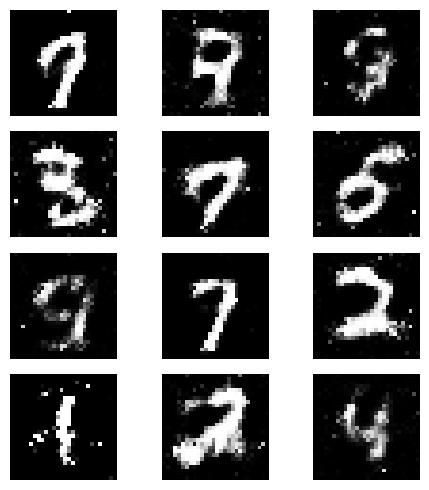

Time for epoch 145 is 3.11 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


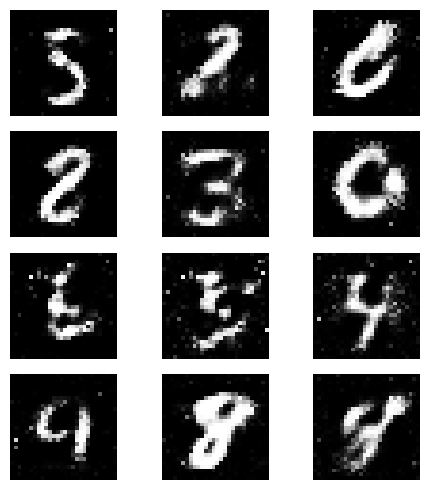

Time for epoch 150 is 1.78 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


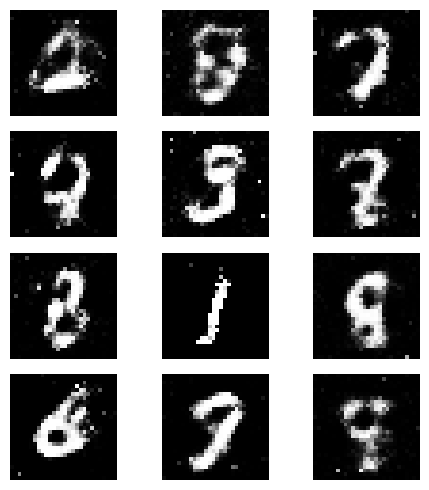

Time for epoch 155 is 1.82 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


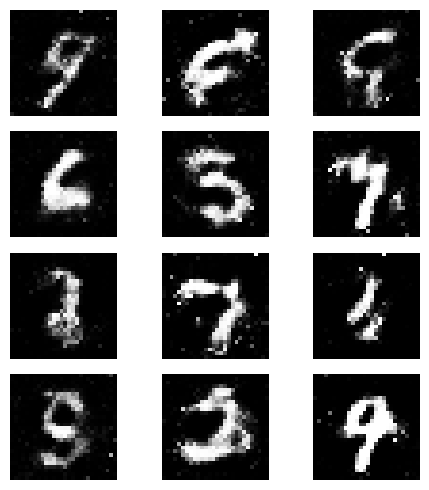

Time for epoch 160 is 2.08 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


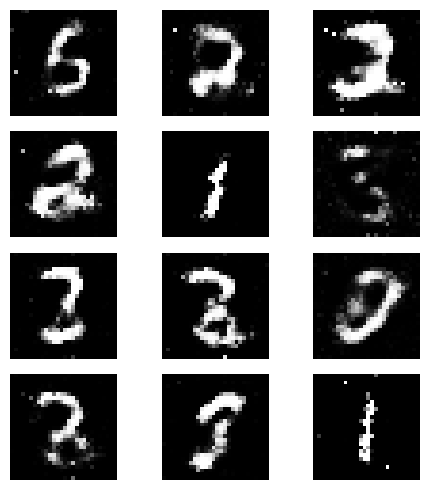

Time for epoch 165 is 2.37 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


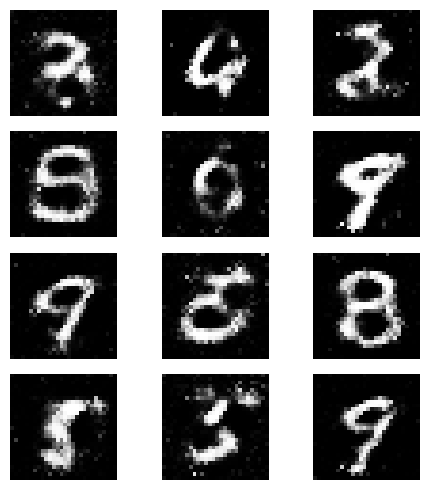

Time for epoch 170 is 2.49 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


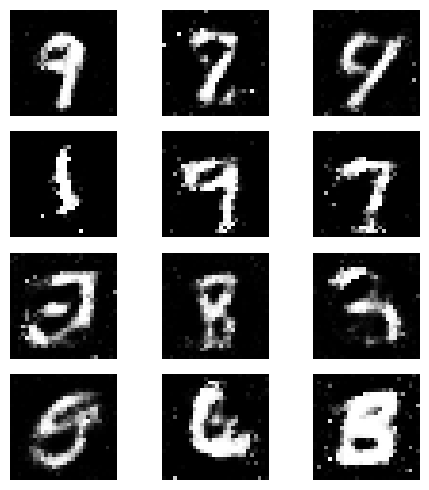

Time for epoch 175 is 2.20 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


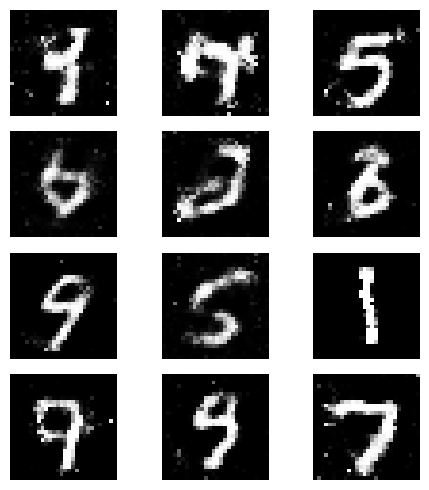

Time for epoch 180 is 2.57 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


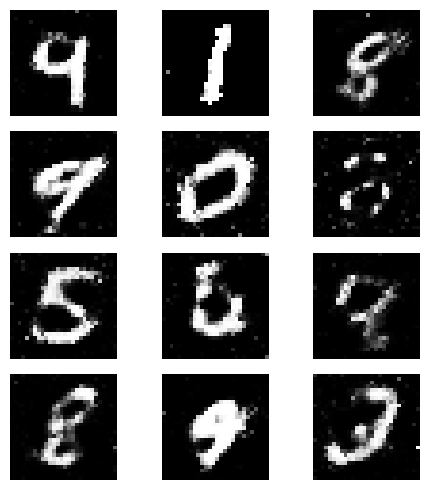

Time for epoch 185 is 2.08 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


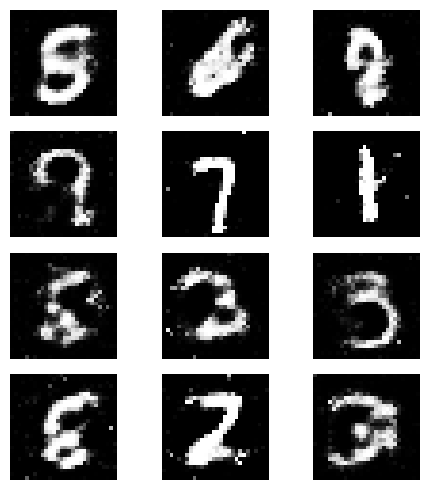

Time for epoch 190 is 2.08 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


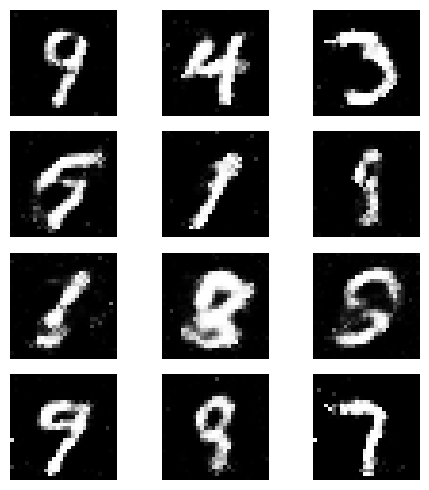

Time for epoch 195 is 1.90 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


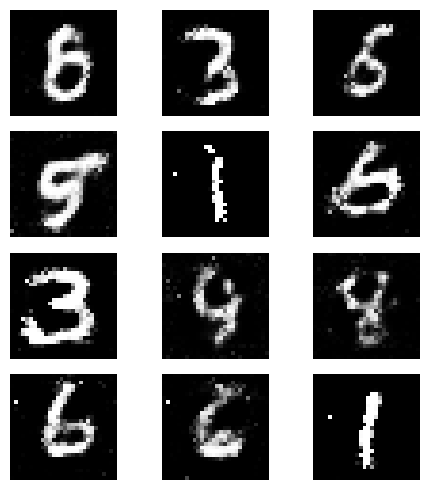

Time for epoch 200 is 1.76 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


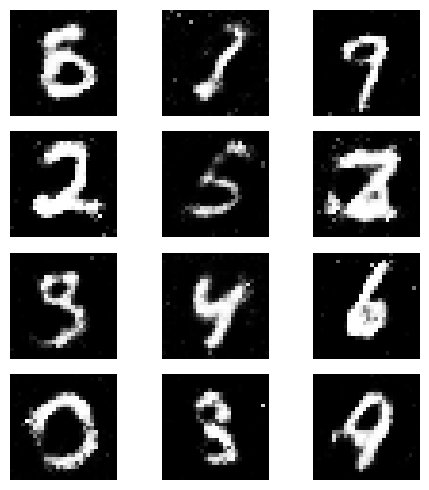

Time for epoch 205 is 2.46 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


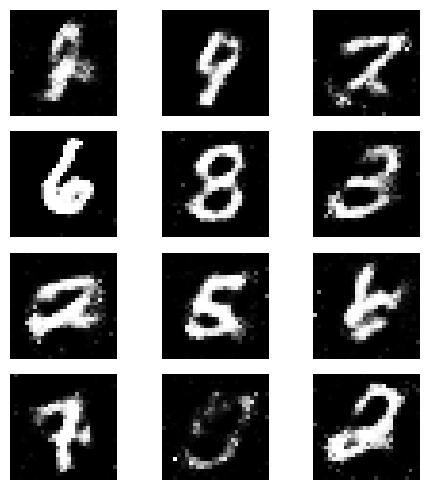

Time for epoch 210 is 1.81 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


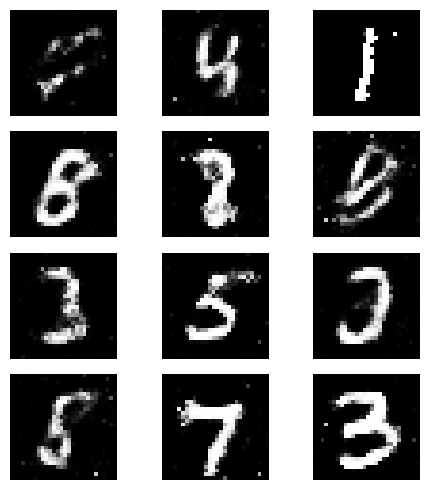

Time for epoch 215 is 2.08 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


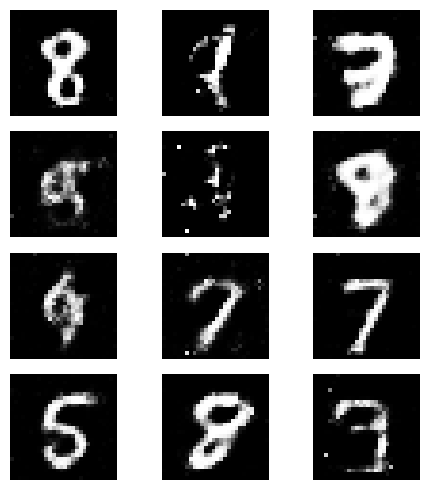

Time for epoch 220 is 2.64 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


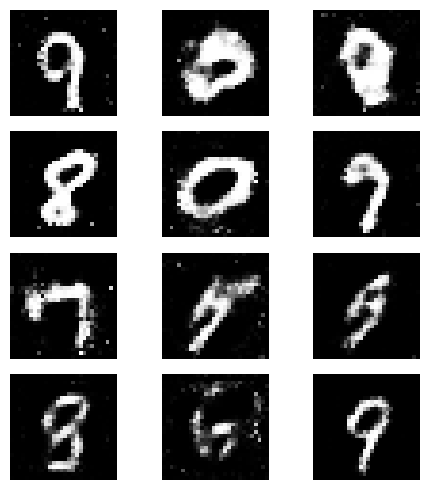

Time for epoch 225 is 1.82 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


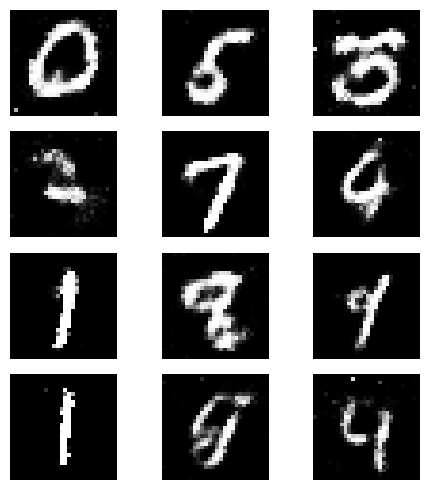

Time for epoch 230 is 2.06 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


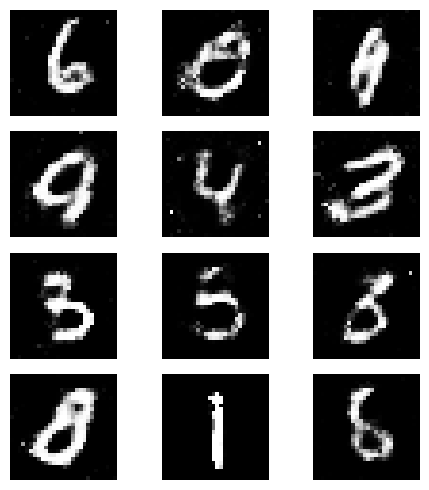

Time for epoch 235 is 1.98 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


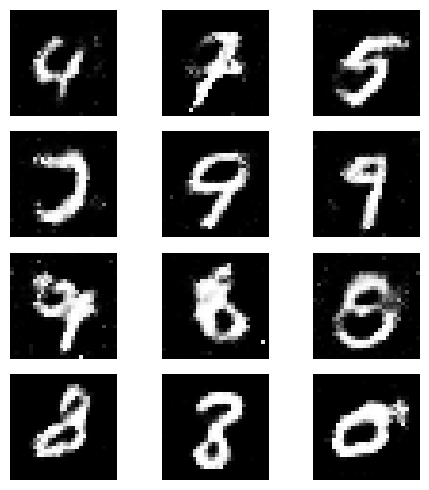

Time for epoch 240 is 1.78 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


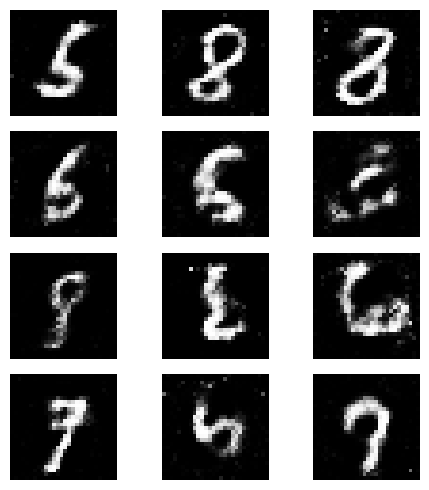

Time for epoch 245 is 2.14 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


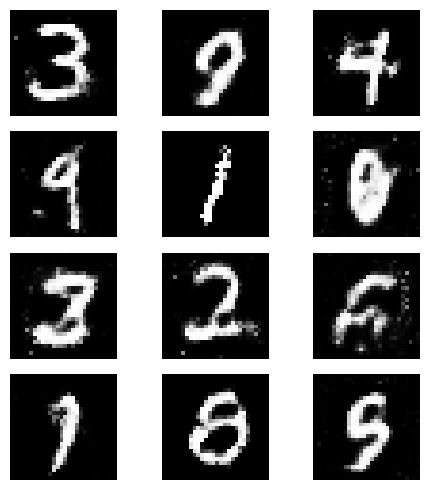

Time for epoch 250 is 1.79 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


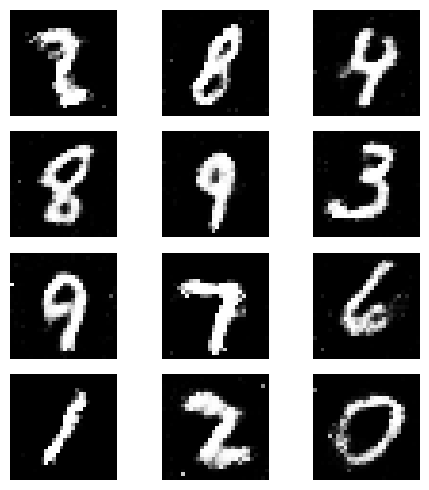

Time for epoch 255 is 1.81 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


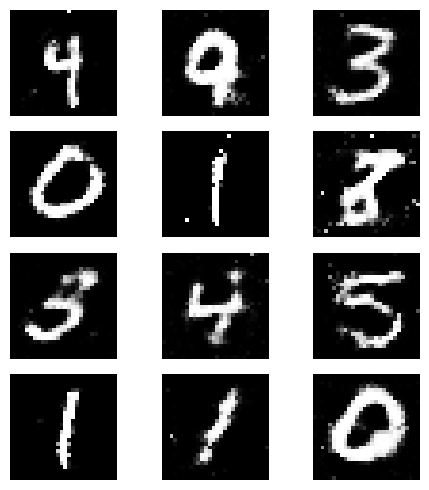

Time for epoch 260 is 2.80 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


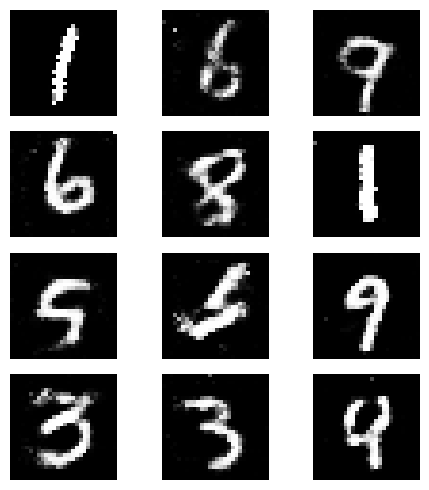

Time for epoch 265 is 1.74 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


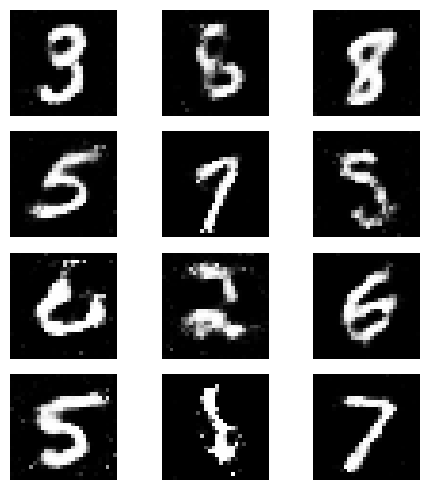

Time for epoch 270 is 1.77 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


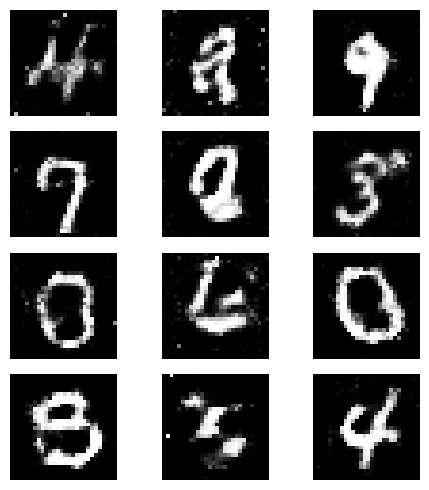

Time for epoch 275 is 1.80 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


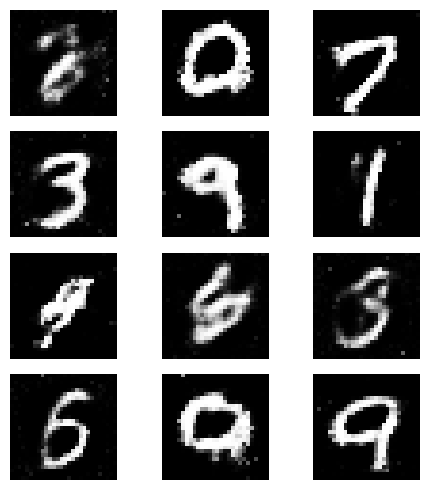

Time for epoch 280 is 1.76 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


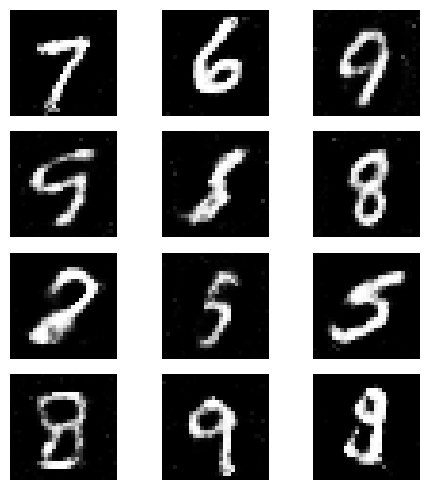

Time for epoch 285 is 2.27 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


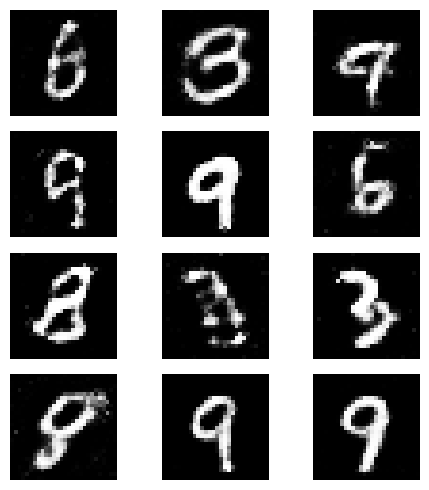

Time for epoch 290 is 2.08 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


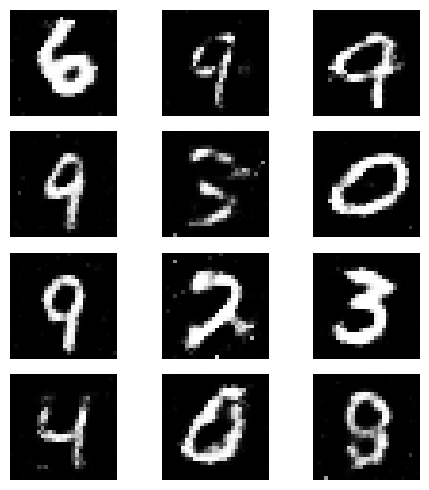

Time for epoch 295 is 1.83 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


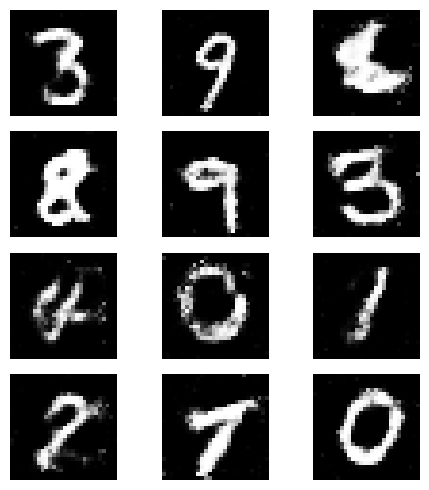

Time for epoch 300 is 2.03 sec


In [20]:
# Start training the GAN
train(train_dataset, EPOCHS, 5)

# **Save Generator Model**

In [21]:
# Save the trained generator model in Keras format
generator.save('generator_model_final.keras')
print("Generator model saved successfully")

Generator model saved successfully


# **Load the model and generate Images**

Generator model loaded successfully.


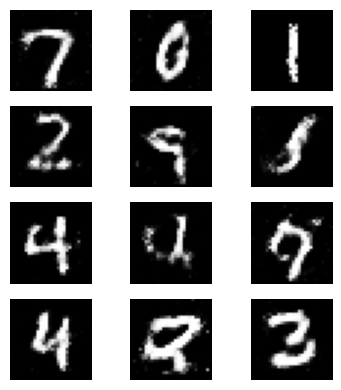

In [22]:
from tensorflow.keras.models import load_model

# Load the saved generator model
generator_trained = load_model('generator_model_final.keras')
print("Generator model loaded successfully.")

# Function to generate and display images
def generate_images(generator, num_images=12, noise_dim=100):
    # Generate random noise vectors
    noise = np.random.normal(0, 1, (num_images, 100))

    # Generate images using the loaded generator
    generated_images = generator(noise, training=False)

    # Rescale images from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1) / 2.0

    # Plot the generated images
    plt.figure(figsize=(4, 4))
    for i in range(num_images):
        plt.subplot(4, 3, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate and display images
generate_images(generator_trained)

# **Visualizing Original Images from Dataset**

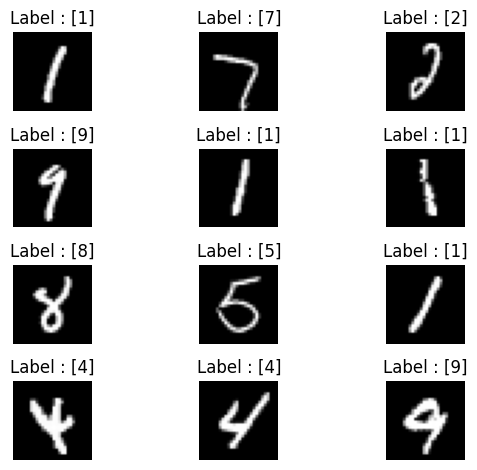

In [32]:
import matplotlib.pyplot as plt
import numpy as np

num_images = 12
for i in range(num_images):
  idx = np.random.randint(0, train_images.shape[0], 1)
  img = train_images[idx]
  label = train_labels[idx]
  plt.subplot(4, 3, i+1)
  plt.imshow(img[0, :, :, 0], cmap = 'gray')
  plt.title(f"Label : {label}")
  plt.axis('off')

plt.tight_layout()
plt.show()

# **Conclusion - The generated images are very similar to Original images.**

# **Save as gif**

In [26]:
# Create an animated GIF of the generated images over epochs
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    # Get the list of image files generated during training
    filenames = glob.glob('gan_generated_image_epoch_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    # Append the last image multiple times for a pause at the end
    for _ in range(10):
        writer.append_data(image)

<ipython-input-26-b105620af487>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
